In [29]:
from random import sample, seed
import numpy as np
import pandas as pd

from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs, Draw, rdMolDescriptors

# Visualization
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})

import mols2grid

import os

# Combinatorial library generation
import itertools
from itertools import combinations_with_replacement

np.random.seed(42)
seed(42)

## Using ReplaceSubstruct from rdkit

In [3]:
scaffolds_df = pd.read_csv("generic_scaffold.csv", dtype={'SMILES' : str})
scaffolds_df.dropna(subset='SMILES', how='any', inplace=True)
scaffolds_df.reset_index(drop=True, inplace=True)
#scaffolds_df.drop('molecules', axis = 1, inplace=True)

#for i in range(len(scaffolds_df.SMILES)):
    #scaffolds_df['mol'][i]=Chem.MolFromSmiles(scaffolds_df['SMILES'][i])
scaffolds_df['mol']=scaffolds_df.SMILES.apply(Chem.MolFromSmiles)

In [4]:
scaffolds_df

Unnamed: 0                                             SMILES  \
0             0            c1ccc(-c2nc3c4cccnc4c4ncccc4c3[nH]2)cc1   
1             1                                c1ccc(-c2ccccn2)nc1   
2             2                   c1ccc2nc3c4cccnc4c4ncccc4c3nc2c1   
3             3                             c1cnc2c(c1)ccc1cccnc12   
4             4                                           c1ccccc1   
..          ...                                                ...   
207         208  O=C(Nc1cc[c-]c(-c2ccccn2)c1)[C@H](OCc1ccccc1)[...   
208         209                    O=c1cc[n-]c(-c2cc(=O)cc[n-]2)c1   
209         210                    O=c1cccc(-c2cccc(=O)[n-]2)[n-]1   
210         211  O=C1CCSCC(C(=O)c2ccc(C(=O)NCCCOCCOCCOCCCn3cc(-...   
211         212                           [c-]1ccccc1/N=N/c1ccccc1   

     occurences                                          molecules  \
0            51  <rdkit.Chem.rdchem.Mol object at 0x000001CF840...   
1            41  <rdkit.Chem.rdchem.Mol object at 0x000001CF840...   
2            32  <rdkit.Chem.rdchem.Mol object at 0x000001CF840...   
3            26  <rdkit.Chem.rdchem.Mol object at 0x000001CF840...   
4            22  <rdkit.Chem.rdchem.Mol object at 0x000001CF840...   
..          ...                                                ...   
207           1  <rdkit.Chem.rdchem.Mol object at 0x000001CFA09...   
208           1  <rdkit.Chem.rdchem.Mol object at 0x000001CFA09...   
209           1  <rdkit.Chem.rdchem.Mol object at 0x000001CFA09...   
210           1  <rdkit.Chem.rdchem.Mol object at 0x000001CFA09...   
211           1  <rdkit.Chem.rdchem.Mol object at 0x000001CFA09...   

                                                   mol  
0    <rdkit.Chem.rdchem.Mol object at 0x00000134CA8...  
1    <rdkit.Chem.rdchem.Mol object at 0x00000134CA8...  
2    <rdkit.Chem.rdchem.Mol object at 0x00000134CA8...  
3    <rdkit.Chem.rdchem.Mol object at 0x00000134CA8...  
4    <rdkit.Chem.rdchem.Mol object at 0x00000134CA8...  
..                                                 ...  
207  <rdkit.Chem.rdchem.Mol object at 0x00000134CA8...  
208  <rdkit.Chem.rdchem.Mol object at 0x00000134CA8...  
209  <rdkit.Chem.rdchem.Mol object at 0x00000134CA8...  
210  <rdkit.Chem.rdchem.Mol object at 0x00000134CA8...  
211  <rdkit.Chem.rdchem.Mol object at 0x00000134CA8...  

[212 rows x 5 columns]

In [15]:
# We define a function to functionalise scaffolds by iterative mono-substitution. It takes the scaffolds dataframe, a pattern to substitute
# (eg an aromatic CH) and a list of substituents as arguments.

def func_scaffolds(df, pattern, subs):
    sub_scaf = pd.DataFrame(columns=['mol', 'SMILES'])
    for scaff in df['mol']:
        for sub in subs:
            query=Chem.MolFromSmarts(pattern)
            matches = scaff.GetSubstructMatches(query)
            if matches:
                modif_scaf = Chem.ReplaceSubstructs(scaff, query, Chem.MolFromSmarts(sub))
                mod = pd.DataFrame(modif_scaf, columns=['mol'])
                mod['SMILES'] = mod['mol'].apply(Chem.MolToSmiles)
                mod['mol'] = mod['SMILES'].apply(Chem.MolFromSmiles) # We re-compute mols objects to ensure aromatization 
                sub_scaf = pd.concat([sub_scaf, mod])
    sub_scaf = sub_scaf.drop_duplicates(subset=['SMILES'])

    return sub_scaf

In [16]:
arom_carb='[c;H1]'

subs=['c-C', 'c-N', 'c-N(C)(C)', 'c-OC', 'c-F', 'c-Cl', 'c-C(F)(F)(F)', 'c-C(C)(C)(C)', 'c-c1ccccc1', 'c-c1ccncc1',]
      #'c-C(=O)O', 'c-C(=O)', 'c-c1ccc(-OC)cc1', 'c-c1ccc(-F)cc1','c-c1ccc(-O)cc1',  'c-C(=O)OC']

In [17]:
functionalised_scaffolds=func_scaffolds(scaffolds_df, arom_carb, subs)

In [18]:
mols2grid.display(functionalised_scaffolds, mol_col="mol")

MolGridWidget()

In [20]:
len(functionalised_scaffolds.mol)

17899

In [ ]:
#functionalised_scaffolds.to_csv("functionalised_generic_scaffolds.csv")

### Using our test functionalised ligands to generate a compound library

In [27]:
triplets = list(combinations_with_replacement(test_func['SMILES'], 3)) # We use combinations_with_replacement to avoid having the same ligand triplets in 
                                                                       # a different order (e.g. ABC, BAC, BCA, ACB...)
test_compounds = pd.DataFrame(triplets, columns=['L1', 'L2', 'L3'])
len(triplets)

125580

In [28]:
test_compounds_fraction = test_compounds.sample(n=3000, random_state=42).reset_index(drop=True) # We sample 3000 examples 
test_compounds_fraction

L1  \
0     Cc1ccc2c(n1)c1ncccc1c1[nH]c(-c3ccccc3)nc21   
1     Nc1cnc2c(c1)c1[nH]c(-c3ccccc3)nc1c1cccnc12   
2     Fc1ccc2c(n1)c1ncccc1c1nc(-c3ccccc3)[nH]c21   
3       Nc1ccnc2c3ncccc3c3nc(-c4ccccc4)[nH]c3c12   
4     Cc1ccc2c(n1)c1ncccc1c1nc(-c3ccccc3)[nH]c21   
...                                          ...   
2995  Cc1cnc2c(c1)c1[nH]c(-c3ccccc3)nc1c1cccnc12   
2996      Cc1ccccc1-c1nc2c3cccnc3c3ncccc3c2[nH]1   
2997    Cc1cccc(-c2nc3c4cccnc4c4ncccc4c3[nH]2)c1   
2998      Nc1ccccc1-c1nc2c3cccnc3c3ncccc3c2[nH]1   
2999    Cc1ccc(-c2nc3c4cccnc4c4ncccc4c3[nH]2)cc1   

                                                     L2  \
0           Clc1ccc2c(n1)c1ncccc1c1nc(-c3ccccc3)[nH]c21   
1        CN(C)c1cnc2c(c1)c1nc(-c3ccccc3)[nH]c1c1cccnc12   
2         CC(C)(C)c1ccccc1-c1nc2c3cccnc3c3ncccc3c2[nH]1   
3     FC(F)(F)c1cnc2c(c1)c1nc(-c3ccccc3)[nH]c1c1cccnc12   
4     CC(C)(C)c1ccc2c(n1)c1ncccc1c1[nH]c(-c3ccccc3)nc21   
...                                                 ...   
2995         Nc1ccc2c(n1)c1ncccc1c1[nH]c(-c3ccccc3)nc21   
2996        COc1ccc2c(n1)c1ncccc1c1nc(-c3ccccc3)[nH]c21   
2997     CN(C)c1ccc2c(n1)c1ncccc1c1[nH]c(-c3ccccc3)nc21   
2998           Fc1ccnc2c3ncccc3c3[nH]c(-c4ccccc4)nc3c12   
2999        COc1ccc2c(n1)c1ncccc1c1[nH]c(-c3ccccc3)nc21   

                                                     L3  
0     c1cc(-c2ccnc3c4ncccc4c4[nH]c(-c5ccccc5)nc4c23)...  
1               COc1ccccc1-c1nc2c3cccnc3c3ncccc3c2[nH]1  
2     c1cc(-c2cccc(-c3nc4c5cccnc5c5ncccc5c4[nH]3)c2)...  
3     c1cc(-c2ccc(-c3nc4c5cccnc5c5ncccc5c4[nH]3)cc2)...  
4     c1ccc(-c2ccc3c(n2)c2ncccc2c2[nH]c(-c4ccccc4)nc...  
...                                                 ...  
2995     CN(C)c1ccc2c(n1)c1ncccc1c1[nH]c(-c3ccccc3)nc21  
2996  c1cc(-c2cnc3c(c2)c2nc(-c4ccccc4)[nH]c2c2cccnc2...  
2997           Fc1ccnc2c3ncccc3c3nc(-c4ccccc4)[nH]c3c12  
2998        Clc1cnc2c(c1)c1nc(-c3ccccc3)[nH]c1c1cccnc12  
2999  c1cc(-c2ccc3c(n2)c2ncccc2c2nc(-c4ccccc4)[nH]c3...  

[3000 rows x 3 columns]

In [51]:
#test_compounds_fraction.to_csv("complexes.csv")

## Mol to XYZ file converter to use the molfunc library (abandoned, but the converter works)

In [3]:
# Define the folder where we are creating the xyz files for the scaffolds
folder_name = 'xyz_scaffolds'

# Get the current directory where the script is located
current_directory = os.getcwd()

# Define the folder path
folder_path = os.path.join(current_directory, folder_name)

if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Define the file path (including the file name and extension) within the new folder


In [1]:
def mol_to_xyz(molecule, fragment_name):
    molecule = Chem.AddHs(molecule)
    number_of_atoms=molecule.GetNumAtoms()
    AllChem.AssignAtomChiralTagsFromStructure(molecule,confId=-1,replaceExistingTags=True)
    AllChem.EmbedMultipleConfs(molecule)
    AllChem.UFFOptimizeMolecule(molecule)
    charge = Chem.GetFormalCharge(molecule)
    file_name = fragment_name+".xyz"
    file_path = os.path.join(folder_path, file_name)
    #print(fragment_name)
    with open(file_path, "w") as file:
        file.write(str(number_of_atoms)+"\n")
        for i, atom in enumerate(molecule.GetAtoms()):
            positions = molecule.GetConformer().GetAtomPosition(i)
            line=" ".join((atom.GetSymbol(), str(positions.x), str(positions.y), str(positions.z), "\n"))
            file.write(line)
        if charge !=0:
            file.write("$set\n")
            file.write("chrg "+str(charge)+"\n")
            file.write("$end")

In [ ]:
scaffolds_df = pd.read_csv("generic_scaffold.csv", dtype={'SMILES' : str})
scaffolds_df.dropna(subset='SMILES', how='any', inplace=True)
scaffolds_df.reset_index(drop=True, inplace=True)
#scaffolds_df.drop('molecules', axis = 1, inplace=True)

#for i in range(len(scaffolds_df.SMILES)):
    #scaffolds_df['mol'][i]=Chem.MolFromSmiles(scaffolds_df['SMILES'][i])
scaffolds_df['mol']=scaffolds_df.SMILES.apply(Chem.MolFromSmiles)

In [ ]:
scaffolds_df.tail(10)

In [30]:

for i in range(len(scaffolds_df['molecules'])) :
    name=str(scaffolds_df.index[i])
    mol=scaffolds_df.mol[i]
    mol_to_xyz(mol, name)

NameError: name 'mol_to_xyz' is not defined

The 207th entry SMILES is either wrong or not recognized, caused an error systematically ; removed it.

In [ ]:
#scaffolds_df=scaffolds_df.drop(207, axis=0)
#scaffolds_df.reset_index(drop=True, inplace=True)

In [ ]:
pip install --upgrade setuptools

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install pip --upgrade

In [ ]:
pip install cython

  Using cached Cython-3.0.10-cp310-cp310-win_amd64.whl.metadata (3.2 kB)
Using cached Cython-3.0.10-cp310-cp310-win_amd64.whl (2.8 MB)
Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install molfunc

Note: you may need to restart the kernel to use updated packages.


In [36]:
from molfunc import CoreMolecule, CombinedMolecule, FragmentMolecule

In [9]:
fragments = {
    "NMe2": "CN([Fr])C",
    "NH2": "N[Fr]",
    "OH": "O[Fr]",
    "Me": "C[Fr]",
    "F": "F[Fr]",
    "OMe" : "CO[Fr]",
    "Cl" : "Cl[Fr]",
    "tBu" : "(C)(C)(C)C[Fr]",
    "Ph" : "c1ccccc1[Fr]",
    "p-Py" : "c1ccncc1[Fr]"
}

In [36]:
#from google.colab import drive
#drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
#xyz_directory_path = '/content/drive/MyDrive/ml_ruthenium_complexes/xyz_scaffolds'


In [10]:
def atoms_to_sub(mol):
  Chem.SanitizeMol(mol)
  Chem.SetAromaticity(mol)
  atoms_list=[]
  for atom in mol.GetAtoms():
    if atom.GetIsAromatic() and atom.GetAtomicNum() == 6:
      num_hydrogens = sum(1 for neighbor in atom.GetNeighbors() if neighbor.GetAtomicNum() == 1)
      if num_hydrogens == 1:
        atoms_list.append(atom.GetIdx())
    else:
      if atom.GetAtomicNum() == 6:
        num_hydrogens = sum(1 for neighbor in atom.GetNeighbors() if neighbor.GetAtomicNum() == 1)
        if num_hydrogens >=1:
          atoms_list.append(atom.GetIdx())
  return atoms_list

In [11]:
def functionalize_scaffolds(directory):
  for filename in os.listdir(directory):
    if filename.endswith('.xyz'):
      file_path = os.path.join(directory, filename)
    mol = Chem.MolFromXYZFile(file_path)
    atoms=atoms_to_sub(mol)
    core_mol=CoreMolecule(filename, atoms)
    for name, smiles in fragments.items():
      combined = CombinedMolecule(core_mol, frag_smiles=smiles, name=filename+f"_{name}")
  return combined

In [38]:
current_directory = os.getcwd()
relative_folder_path = 'test_folder'
absolute_folder_path = os.path.join(current_directory, relative_folder_path)

#functionalize_scaffolds(absolute_folder_path)

filename=os.listdir(absolute_folder_path)[0]
filename
file_path=os.path.join(absolute_folder_path, filename)
file_path
core_mol=CoreMolecule(xyz_filename=file_path, atoms_to_del=[29])
FragmentMolecule(xyz_filename=file_path)
combined = CombinedMolecule(core_mol=core_mol, frag_smiles="C[Fr]", name="test")

RAtomNotFound: 

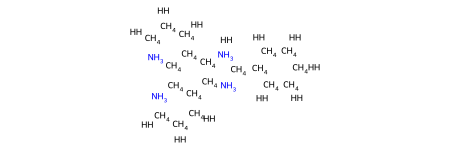

In [53]:
mol=Chem.MolFromXYZFile('/content/drive/MyDrive/ml_ruthenium_complexes/test_directory/test.xyz')
mol

In [14]:
print_combined_molecule('test.xyz',
                        atoms_to_del=[29],
                        frag_names=['Me'],
                        name='test_combined')

RuntimeError: Failed to open: test.xyz